Load Julia packages (libraries) needed  for the snippets in chapter 0

In [1]:
using StatisticalRethinking, CmdStan, StanMCMCChain, LinearAlgebra
gr(size=(500,500));

CmdStan uses a tmp directory to store the output of cmdstan

In [2]:
ProjDir = rel_path("..", "scripts", "04")
cd(ProjDir)

### snippet 4.7

In [3]:
howell1 = CSV.read(rel_path("..", "data", "Howell1.csv"), delim=';')
df = convert(DataFrame, howell1);

Use only adults

In [4]:
df2 = filter(row -> row[:age] >= 18, df);
first(df2, 5)

,height,weight,age,male
,Float64⍰,Float64⍰,Float64⍰,Int64⍰
1,151.765,47.8256,63.0,1
2,139.7,36.4858,63.0,0
3,136.525,31.8648,65.0,0
4,156.845,53.0419,41.0,1
5,145.415,41.2769,51.0,0


Use data from m4.1s

Check if the m4.1s.jls file is present. If not, run the model.

In [5]:
!isfile(joinpath(ProjDir, "m4.1s.jls")) && include(joinpath(ProjDir, "m4.1s.jl"))

chn = deserialize(joinpath(ProjDir, "m4.1s.jls"))

Object of type "Chains{Float64}"

Iterations = 1:1000
Thinning interval = 1
Chains = 1,2,3,4
Samples per chain = 1000

Union{Missing, Float64}[7.46707 155.422; 7.45383 155.281; … ; 7.98575 154.245; 8.04835 154.215]

Union{Missing, Float64}[7.88199 155.276; 7.48773 154.015; … ; 7.89871 154.166; 8.3996 154.563]

Union{Missing, Float64}[8.15755 154.547; 8.47548 154.716; … ; 7.70387 154.626; 7.48739 154.178]

Union{Missing, Float64}[7.2983 154.706; 7.58751 154.615; … ; 7.37117 154.782; 7.43163 154.572]

Describe the draws

In [6]:
describe(chn)

Iterations = 1:1000
Thinning interval = 1
Chains = 1,2,3,4
Samples per chain = 1000

Empirical Posterior Estimates:
          Mean        SD       Naive SE       MCSE      ESS
sigma   7.7678857 0.29426128 0.0046526793 0.0057126047 1000
   mu 154.6015647 0.41946676 0.0066323518 0.0058409616 1000

Quantiles:
          2.5%       25.0%       50.0%      75.0%       97.5%  
sigma   7.2243845   7.5640175   7.758795   7.9647725   8.379076
   mu 153.7959750 154.3120000 154.600500 154.8892500 155.450025



Plot the density of posterior draws

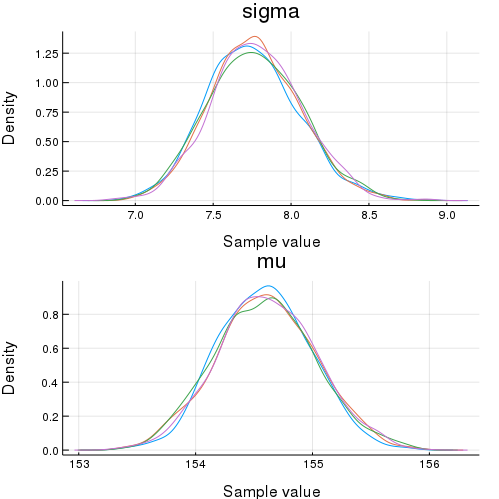

In [7]:
density(chn, lab="All heights", xlab="height [cm]", ylab="density")

Compute cor

In [8]:
mu_sigma = hcat(chn.value[:, 2, 1], chn.value[:,1, 1])
LinearAlgebra.diag(cov(mu_sigma))

2-element Array{Float64,1}:
 0.15574280896496506
 0.0890752512803427 

Compute cov

In [9]:
cor(mu_sigma)

2×2 Array{Float64,2}:
  1.0        -0.0106086
 -0.0106086   1.0      

End of `clip_07.0s.jl`

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*